In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
import os
import sys
import glob
import random

from pprint import pprint
from ipywidgets import Video

from PIL import Image
from PIL.ExifTags import TAGS

from sklearn.cluster import KMeans

In [2]:
# dysk Ani
!gdown --id 1OjFFysQD-MbhiTzfesrvXqkIg6oNRIyK
# dysk Agi
!gdown --id 1APJsddWLOTyYxlgK-nHNK9o6AU_B-NgY

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1OjFFysQD-MbhiTzfesrvXqkIg6oNRIyK
To: /content/roonie_snooker.mp4
100% 6.24M/6.24M [00:00<00:00, 197MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1APJsddWLOTyYxlgK-nHNK9o6AU_B-NgY
To: /content/test.mp4
100% 3.30M/3.30M [00:00<00:00, 187MB/s]


In [3]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

In [4]:
def open_video(path):
  video = cv2.VideoCapture(path)
  if not video.isOpened():
      print("[ERROR]: Could not open video from the given path.")

  video_width = int(video.get(3))
  video_height = int(video.get(4))
  video_fps = video.get(cv2.CAP_PROP_FPS)
  print(f"Video: width={video_width} height={video_height} fps={video_fps}")

  return video, video_width, video_height, video_fps

In [5]:
def detect_edges(frame):
  gray_f = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  threshold_f = cv2.adaptiveThreshold(gray_f, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 19, -12)
  lines = cv2.HoughLinesP(threshold_f, rho=2, theta=np.pi/20, threshold=600, minLineLength=400, maxLineGap=50)
  return lines


def detect_edge_intersection(lines, tolerance=0.1):
  def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
      return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
      raise Exception('Determinant equals zero.')

    d = (det(*line1), det(*line2))
    x = int(det(d, xdiff) / div)
    y = int(det(d, ydiff) / div)
    return x, y
  
  intersection_points = []
  for line1 in lines:
    x1, y1, x2, y2 = line1[0]
    for line2 in lines:
      x3,y3,x4,y4 = line2[0]
      m1 = abs((y2 - y1) / (x2 - x1))
      m2 = abs((y4 - y3) / (x4 - x3))
      if abs(m1 - m2) > tolerance:
        intersection_point = line_intersection(((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)))
        intersection_points.append(intersection_point)
  return intersection_points


def detect_table_corners(intersection_points, n_clusters=4):
  # remove intersection points from the top of the frame
  for intersection_point in intersection_points:
    _, y = intersection_point
    if y < 10:
      intersection_points.remove(intersection_point)

  # perform k-means to detect table corners
  intersection_points = np.asarray(intersection_points).astype(np.float32)
  model = KMeans(n_clusters=n_clusters)
  model.fit(intersection_points)
  segments = model.predict(intersection_points)
  corners = np.stack([intersection_points[segments==i].mean(0) for i in range(n_clusters)], 0)

  return corners.astype(int)


def draw_table_borders(frame, tolerance=2):
  # detect edges
  lines = detect_edges(frame)
  # detect edge intersection
  intersection_points = detect_edge_intersection(lines)
  # detect table corners
  corners = detect_table_corners(intersection_points)
  for corner1 in corners:
    for corner2 in corners:
      if abs(corner1[0] - corner2[0]) < tolerance or abs(corner1[1] - corner2[1]) < tolerance:
        cv2.line(frame, corner1, corner2, (255, 0, 0), 5)
  return frame

Video: width=1280 height=720 fps=25.0


<ipython-input-5-5e43fd3d78bd>:31: RuntimeWarning: divide by zero encountered in int_scalars
  m2 = abs((y4 - y3) / (x4 - x3))
<ipython-input-5-5e43fd3d78bd>:30: RuntimeWarning: divide by zero encountered in int_scalars
  m1 = abs((y2 - y1) / (x2 - x1))
<ipython-input-5-5e43fd3d78bd>:32: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m1 - m2) > tolerance:
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


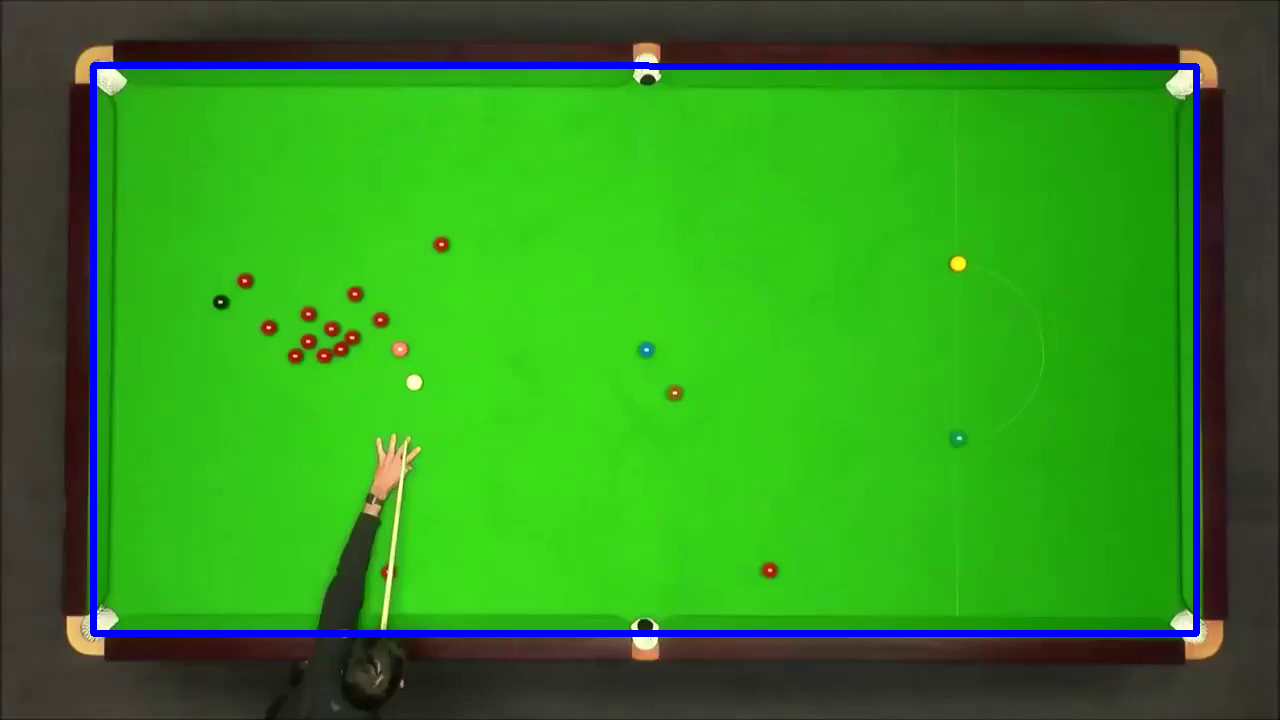

In [6]:
video, video_width, video_height, video_fps = open_video('./roonie_snooker.mp4')
# video_track = cv2.VideoWriter('./roonie_snooker.avi', cv2.VideoWriter_fourcc(*'DIVX'), video_fps, (video_width, video_height))

video.set(cv2.CAP_PROP_POS_FRAMES, 0)
for i in range(1):
    ret, frame = video.read()

    if ret:
        # draw table borders
        _frame = draw_table_borders(frame)
        imshow(_frame)
    else:
        break

# video_track.release()
# !ffmpeg -hide_banner -loglevel error -i roonie_snooker.avi -y roonie_snooker.mp4
# Video.from_file('./roonie_snooker.mp4', width=video_width, height=video_height)